# Introduction

We will create some helper functions in python to save some time and use a context manager to handle the connection to the SQLite database.

In [1]:
import sqlite3
import pandas as pd
import matplotlib as plt
%matplotlib inline

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q,conn)

def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
    
def show_tables():
    q='Select name, type from sqlite_master where type In ("table","view");'
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [2]:
q1 = '''select g.name as genre, SUM(il.quantity) as number_sold, 
CAST(SUM(il.quantity) as float)/(select sum(quantity) from invoice_line) as percentage
from genre as g
inner JOIN track as t ON g.genre_id=t.genre_id
INner JOin invoice_line as il ON il.track_id = t.track_id
Group by 1
'''

run_query(q1)

,genre,number_sold,percentage
0,Alternative,117,0.024595
1,Alternative & Punk,492,0.103427
2,Blues,124,0.026067
3,Classical,47,0.009880
4,Drama,1,0.000210
5,Easy Listening,74,0.015556
6,Electronica/Dance,55,0.011562
7,Heavy Metal,8,0.001682
8,Hip Hop/Rap,33,0.006937
9,Jazz,121,0.025436


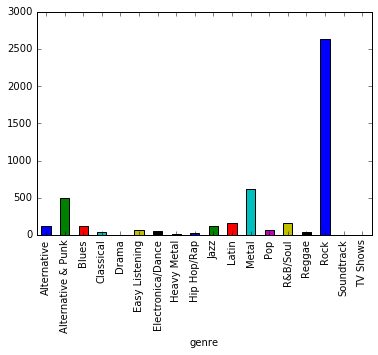

In [3]:
data1 = run_query(q1)
data1.set_index("genre",drop=True,inplace=True)
data1['number_sold'].plot.bar()

In [4]:
q2 = '''select g.name as genre, SUM(il.quantity) as number_sold, 
CAST(SUM(il.quantity) as float)/(select sum(quantity) from invoice_line) as percentage
from genre as g
left JOIN track as t ON g.genre_id=t.genre_id
left JOin invoice_line as il ON il.track_id = t.track_id
Group by 1
'''
run_query(q2)

,genre,number_sold,percentage
0,Alternative,117.0,0.024595
1,Alternative & Punk,492.0,0.103427
2,Blues,124.0,0.026067
3,Bossa Nova,NaN,NaN
4,Classical,47.0,0.009880
5,Comedy,NaN,NaN
6,Drama,1.0,0.000210
7,Easy Listening,74.0,0.015556
8,Electronica/Dance,55.0,0.011562
9,Heavy Metal,8.0,0.001682


Finds the total dollar amount of sales assigned to each sales support agent within the company.

In [5]:
q3 = '''select 
e.first_name || ' ' || e.last_name as employee_name,
SUM(i.total) as total_sales from employee as e
Inner Join customer as c On c.support_rep_id = e.employee_id
Inner Join invoice as i on i.customer_id = c.customer_id
group by 1
order by 1;
'''
run_query(q3)

,employee_name,total_sales
0,Jane Peacock,1731.51
1,Margaret Park,1584.00
2,Steve Johnson,1393.92


In [6]:
q4 = '''select 
e.first_name || ' ' || e.last_name as employee_name
from employee as e
Left Join customer as c On c.support_rep_id = e.employee_id
left Join invoice as i on i.customer_id = c.customer_id
where e.title = 'Sales Support Agent'
group by 1
order by 1;
'''
run_query(q4)

,employee_name
0,Jane Peacock
1,Margaret Park
2,Steve Johnson


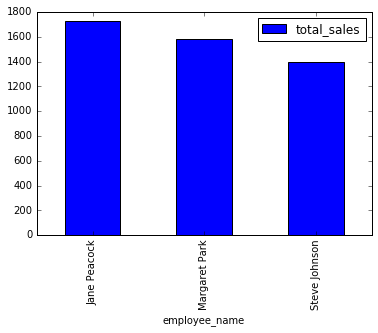

In [7]:
data2 = run_query(q3)
data2.set_index("employee_name",drop=True,inplace=True)
data2.plot.bar()

Collects data on purchases from different countries, where a country has only one customer, collect them into an 'other' group

In [8]:
q5='''With countrydata AS(
     select c.country, count(DISTINCT c.customer_id) as total_customers,SUM(i.total) as total_sales,
SUM(i.total)/cast(count(DISTINCT c.customer_id) as float) as avg_sales_per_customer,
SUM(i.total)/cast(count(i.invoice_id) as float) as avg_order_value
from customer as c
Inner Join invoice as i On c.customer_id = i.customer_id
group by 1
order by 3 desc   
)

select
    CASE WHEN total_customers = 1 THEN 'other'
         ELSE country END AS country_other,
    SUM(total_customers) as total_customers,
    SUM(total_sales) as total_sales,
    AVG(avg_sales_per_customer) as avg_sales_per_customer,
    AVG(avg_order_value) as avg_order_value
     
from countrydata
group by 1
order by CASE 
    WHEN country_other = 'other' THEN 1
    ELSE 0
    END,
    total_sales desc
'''
run_query(q5)

,country_other,total_customers,total_sales,avg_sales_per_customer,avg_order_value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,other,15,1094.94,72.996000,7.445071


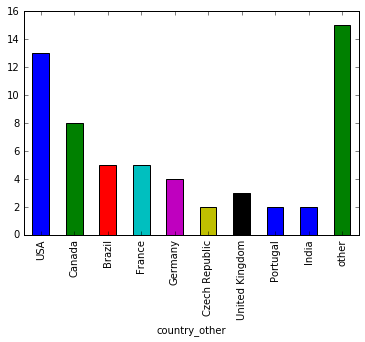

In [16]:
data3 = run_query(q5)
data3.set_index('country_other',drop=True,inplace=True)

data3['total_customers'].plot.bar()

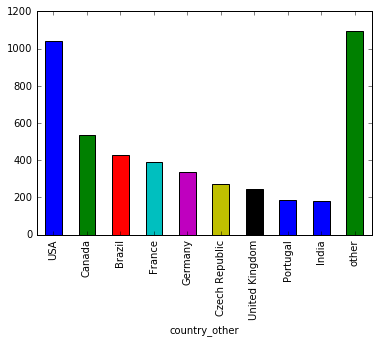

In [17]:
data3['total_sales'].plot.bar()

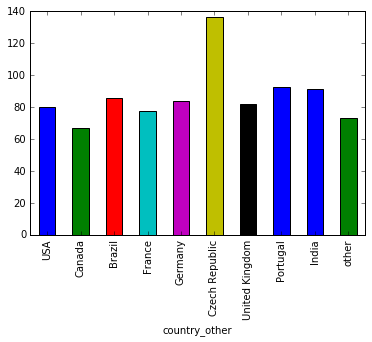

In [18]:
data3['avg_sales_per_customer'].plot.bar()

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks seperately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album. We want to find out what percentages of purchases are individual tracks vs whole albums, so that management can use the data to understand the effect this decision might have an overall revenue.

Categorizes each invoice as either an album purchase or not, and calculates the following summary statistics:
    1. Number of invoices
    2. Percentage of invoices

In [30]:
q6 = '''With purchase_list as
    (select il.invoice_id, il.track_id, t.album_id
     from invoice_line as il
     inner join track as t on il.track_id = t.track_id
     ),
     album_songs as 
     (select a.album_id,t.track_id from album as a
     inner join track as t on a.album_id = t.album_id
     ),
     
     album_purchase_data as
     (select pl.invoice_id, 
         CASE WHEN 
         (select ass.track_id from album_songs as ass where pl.album_id = ass.album_id
         EXCEPT
          select il.track_id from invoice_line as il where pl.invoice_id = il.invoice_id
         ) IS NULL
         AND
         (select il.track_id from invoice_line as il where pl.invoice_id = il.invoice_id
         EXCEPT
          select ass.track_id from album_songs as ass where pl.album_id = ass.album_id
         ) IS NULL THEN 1
         ELSE 0 END AS album_purchase
    from purchase_list as pl 
    GROUP BY 1)
    
    select count(invoice_id) as number_invoices, cast(SUM(album_purchase) as float)/count(invoice_id) as album_percentage
    from album_purchase_data
'''
run_query(q6)

,number_invoices,album_percentage
0,614,0.185668


# Conclusion

It shows the whole album purchases which is 18.6% of total invoices. It means the company can go ahead with the strategy of not buying the whole album and buying selected famous tracks.